<a href="https://colab.research.google.com/github/MariaEspFon/Scripts-propios/blob/main/TensorFlow/CNN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# MODELO 1: red neuronal convolucional (CNN)

## 1. Inicialización de Keras y TensorFlow

In [16]:
%tensorflow_version 2.x
import tensorflow as tf
print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("TensorFlow version: ", tf.__version__)

from tensorflow import keras
#print("Keras version: ", tf.keras.__version__)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%reload_ext tensorboard

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version:  2.18.0


## 2. Carga de datos EDA desde Github

In [76]:
url = 'https://raw.githubusercontent.com/MariaEspFon/Scripts-propios/main/MATLAB/EDA_data.csv'
column_names = ['Median', 'Standard Dev', 'Max Value', 'Min Value', 'Median 1st diff', 'Standard Dev 1st diff', 'Number of SCR', 'Total Area', 'Power', 'State' ]
raw_dataset = pd.read_csv(url, names=column_names, sep=',', skipinitialspace=True)

size = raw_dataset.shape
print(f'Formato del dataset: {size}')

Formato del dataset: (4471, 10)


In [ ]:
raw_dataset.tail() # muestra las últimas 5 filas por defecto

In [ ]:
raw_dataset.head() # muestra las primeras 5 filas por defecto

## 3. Preprocesamiento de datos

### 3.1. Extracción de los conjuntos de entrenamiento, prueba y validación

*   Datos de **entrenamiento**: para el aprendizaje de parámetros.
*   Datos de **prueba**: para hacer test de predicciones.
*   Datos de **validación**: para afinar hiperparámetros.



In [95]:
train_dataset = raw_dataset.sample(frac=0.8,random_state=0)
# random_state=0 marca la semilla aleatoria para escoger muestras
test_dataset = raw_dataset.drop(train_dataset.index)
# drop coge el resto de datos desde la posición final de train_dataset

In [96]:
train_labels = train_dataset.pop('State')
test_labels = test_dataset.pop('State')
del train_dataset['Number of SCR']
del test_dataset['Number of SCR']
#del train_dataset['Median 1st diff']
#del train_dataset['Standard Dev 1st diff']
#del test_dataset['Median 1st diff']
#del test_dataset['Standard Dev 1st diff']


In [97]:
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Median,3577.0,1.369230,2.557778,2.351932e-22,0.237412,0.416184,0.987953,17.070575
Standard Dev,3577.0,0.141251,0.345816,7.476786e-04,0.006451,0.030620,0.116392,5.383384
Max Value,3577.0,1.622600,2.811966,6.211061e-03,0.297770,0.492833,1.346439,20.546044
Min Value,3577.0,1.068527,2.316840,-2.450087e-01,0.072111,0.279829,0.618816,16.056648
Median 1st diff,3577.0,0.032563,0.057137,4.908710e-04,0.002001,0.008695,0.036407,1.132397
Standard Dev 1st diff,3577.0,-0.000706,0.003271,-5.691210e-02,-0.000499,-0.000083,0.000077,0.050073
Total Area,3577.0,162.308289,302.559923,3.457700e-02,28.259939,49.243425,119.233737,2020.010062
Power,3577.0,1015.134579,3544.094472,1.827353e-04,7.250991,21.803820,137.946670,34729.312397


### 3.2. Normalización y estandarización de todos los datos

In [98]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)
train_size = normed_train_data.shape
test_size = normed_test_data.shape
print(f'Formato del dataset de training: {train_size}')
print(f'Formato del dataset de test: {test_size}')

Formato del dataset de training: (3577, 8)
Formato del dataset de test: (894, 8)


In [99]:
normed_train_stats = normed_train_data.describe()
normed_train_stats = normed_train_stats.transpose()
normed_train_stats

,count,mean,std,min,25%,50%,75%,max
Median,3577.0,-4.022502e-17,1.0,-0.535320,-0.442500,-0.372607,-0.149066,6.138665
Standard Dev,3577.0,-2.880310e-17,1.0,-0.406295,-0.389804,-0.319914,-0.071886,15.158732
Max Value,3577.0,2.383705e-17,1.0,-0.574825,-0.471140,-0.401771,-0.098209,6.729612
Min Value,3577.0,9.932104e-19,1.0,-0.566951,-0.430075,-0.340420,-0.194105,6.469209
Median 1st diff,3577.0,-9.932104e-19,1.0,-0.561324,-0.534890,-0.417730,0.067279,19.249088
Standard Dev 1st diff,3577.0,-2.185063e-17,1.0,-17.180523,0.063174,0.190586,0.239417,15.521754
Total Area,3577.0,-3.277594e-17,1.0,-0.536336,-0.443047,-0.373694,-0.142367,6.139947
Power,3577.0,9.932104e-18,1.0,-0.286430,-0.284384,-0.280278,-0.247507,9.512776


## 4. Creación del modelo CNN

El primer modelo cuenta con 3 capas principales:
*     Capa de entrada convolucional con 8 filtros (3x1) que opera sobre las muestras de entrada.
*     Capa oculta convolucional con 12 filtros (3x1).
*     Capa de saluda para la clasificación binaria, para la cual sólo es necesaria una neurona y una función sigmoid de activación.

Además, se incluye una capa accesoria para preparar los datos antes de la capa de salida (capa Flatten)

In [100]:
from keras import Sequential, layers

def build_model(size):
  model = Sequential()
  model.add(layers.Conv1D(28, 2, strides=1, padding='same', activation='relu', input_shape=(size[1],1)))
  model.add(layers.Conv1D(21, 3, padding='same', activation='relu'))
  model.add(layers.Conv1D(21, 3, padding='same', activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(21, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))
  return model

model = build_model(train_size)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_60 (Conv1D)                   │ (None, 8, 28)               │              84 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_61 (Conv1D)                   │ (None, 8, 21)               │           1,785 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_62 (Conv1D)                   │ (None, 8, 21)               │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_17 (Flatten)                 │ (None, 168)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 21)                  │           3,549 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 1)                   │              22 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,784 (26.50 KB)

 Trainable params: 6,784 (26.50 KB)

 Non-trainable params: 0 (0.00 B)

Incorporamos el callback de TensorBoard para poder guardar los parámetros, descripción y resultados de cada prueba con el modelo

In [ ]:
from keras import callbacks
import os

# Crear el directorio donde se guardarán los logs de TensorBoard
# log_dir = os.path.join("logs", "fit", "experiment_name")  # Puedes personalizar el nombre
# tensorboard_callback = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


In [101]:
model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

## 5. Entrenamiento del modelo

Reservamos el 20% de los datos de entrenamiento para la validación del modelo

In [102]:
EPOCHS = 500

history = model.fit(normed_train_data, train_labels, batch_size=size[0],
                    epochs=EPOCHS, validation_split = 0.2, verbose=0)

In [103]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,accuracy,loss,val_accuracy,val_loss,epoch
495,0.724572,0.523641,0.652235,0.667158,495
496,0.725970,0.523273,0.655028,0.667381,496
497,0.726319,0.523073,0.656425,0.667732,497
498,0.726319,0.522960,0.648045,0.667618,498
499,0.726669,0.522937,0.653631,0.668532,499


In [104]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Binary Crossentropy')
  plt.plot(hist['epoch'], hist['accuracy'],'r--',
           label='Training Accuracy')
  plt.plot(hist['epoch'], hist['val_accuracy'],'b',
           label = 'Validation Accuracy')
  plt.ylim([0,1])
  plt.legend()
  plt.show()

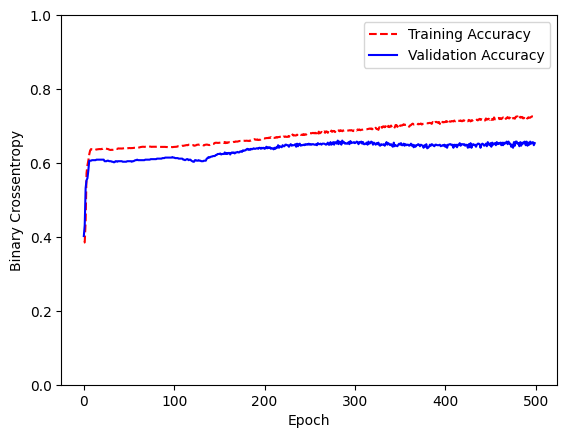

In [105]:
plot_history(history)

## 6. Validación del modelo con los datos de test


In [106]:
test_loss, test_acc = model.evaluate(normed_test_data,  test_labels, batch_size=(test_size[0]))
print(f'Test accuracy: {100*test_acc:.2f}%')
print(f'Test loss: {test_loss:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.6711 - loss: 0.6488
Test accuracy: 67.11%
Test loss: 0.649
